# Clasificación con una capa escondida

En este taller vamos a implementar una red neuronal con una sola capa escondida. Podremos ver la diferencia de este modelo con la regresión logística que implementamos en el taller anterior.

**Tras este taller usted va a ser capaz de:**
- Implementar una red neuronal de una capa escondida para un problema de clasificación binario
- Usar unidades/neuronas con una función de activación no-lineal, como por ejemplo la tanh 
- Computar la función de pérdida de entropía cruzada 
- Implementar la propagación hacia delante y hacia atrás


## 1 - Paquetes ##

Primero, importamos los paquetes que vamos a necesitar a lo largo de este taller. 
- [numpy](www.numpy.org) paquete básico para ciencias computacionales con Python.
- [sklearn](http://scikit-learn.org/stable/) herramientas eficientes para el análisis y la minería de datos. 
- [matplotlib](http://matplotlib.org) librería para graficar en Python.
- testCases tiene los ejemplos de prueba para evaluar la implementacion de las funciones
- planar_utils provee distintas funciones que se van a usar durante el taller

In [1]:
# Importación de paquetes
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils0 import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # se establece una semilla para que los resultados sean iguales (necesario para la corrección del taller)

## 2 - Conjunto de datos ##

Primero, carguemos el conjunto de datos sobre el que se va a trabajar. El siguiente código va a cargar un conjunto de datos en forma de flor, con dos clases en las variables `X` e `Y`.

In [2]:
X, Y = load_planar_dataset()

In [3]:
X.shape[0]

2

Visualice los datos mediante matplotlib. Los datos tienen puntos rojos (y=0) y azules (y=1). El objetivo es el de constuir un modelo que se ajuste a estos datos. 

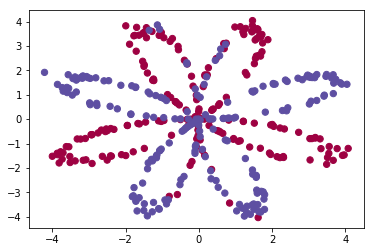

In [4]:
# Visualice los datos:
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

Entonces se tiene una matriz X con los patrones (x1, x2), y un vector Y con las etiquetas (rojo:0, azul:1).

Examinemos a continuación los datos.

**Ejercicio**: Cuántos ejemplos de entrenamiento tenemos? Adicionalmente, cuáles son las dimensiones `shape` de `X` e `Y`? 

**Ayuda**: Recuerde cómo obtener la forma de un arreglo numpy [(ayuda)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [5]:
### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 3 líneas de código)
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]          # tamaño del conjunto de entrenamiento
### TERMINE EL CÓDIGO AQUÍ ###

print ('Las dimensiones de X son: ' + str(shape_X))
print ('Las dimensiones de Y son: ' + str(shape_Y))
print ('Hay m = %d ejemplos de entrenamiento' % (m))

Las dimensiones de X son: (2, 400)
Las dimensiones de Y son: (1, 400)
Hay m = 400 ejemplos de entrenamiento


**Salida esperada**: 
       
<table style="width:40%">
  
  <tr>
    <td>**Dimensiones de X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**Dimensiones de Y**</td>
    <td>(1, 400) </td> 
  </tr>
  
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Regresión Logística

Antes de contruir una red neuronal, primero estudiemos cómo la regresión logística se comporta con este problema. Se pueden utilizar las funciones de sklearn para hacerlo. Ejecute el siguiente código para entrenar un clasificador de regresión logística sobre el conjunto de datos.

In [6]:
# Entrene el clasificador logístico
clf = sklearn.linear_model.LogisticRegressionCV();
Y2=Y.flatten()
clf.fit(X.T, Y2);

Ahora se puede graficar la frontera de decisión de estos modelos. Ejecute el siguiente código.

Precisión de la regresión logística: 47 % (porcentaje de puntos correctamente etiquetados)


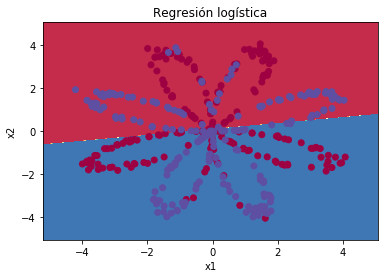

In [7]:
# Grafique la frontera de decisión para la regresión logística
plot_decision_boundary(lambda x: clf.predict(x), X, Y2)
plt.title("Regresión logística")

# Precisión
LR_predictions = clf.predict(X.T)
print ('Precisión de la regresión logística: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(porcentaje de puntos correctamente etiquetados)")

**Salida esperada**: 

<table style="width:20%">
  <tr>
    <td>**Precisión**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Anotación**: como se esperaba, el conjunto de datos no es linealmente separable. Por esto, la regresión logística no logra un buen desempeño. Puede ser que la red neuronal logre un mejor desempeño. Vamos a ver! 

## 4 - Modelo de red neuronal

La regresión logística no logró buenos resultados sobre el conjunto de datos. Ahora debe entrenar una red neuronal con una sola capa escondida.

**Formulación matemática**:

Para un ejemplo $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediccion} = \begin{cases} 1 & \mbox{si } a^{[2](i)} > 0.5 \\ 0 & \mbox{en caso contrario (e.c.c.) } \end{cases}\tag{5}$$

Dadas las predicciones sobre todos los ejemplos, tambien puede computar el coste $J$ como sigue: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Recuerde**: La metodología general para construir una red neuronal:
    1. Definir una estructura de red neuronal ( # de unidades de input,  # de unidades escondidas, etc). 
    2. Inicialice los parámetros del modelo
    3. Bucle:
        - Implemente propagación hacia delante
        - Compute la pérdida
        - Implemente la propagación hacia atrás y obtenga los gradientes
        - Actualice los parámetros (Descenso en la dirección del gradiente: GD)

Se pueden construir funciones auxiliares para computar los pasos 1-3 y luego fusionarlas en una función (madre) llamada `nn_model()`. Una vez construida `nn_model()` y habiendo aprendido los parámetros adecuados, se pueden hacer predicciones sobre nuevos datos.

### 4.1 - Definiendo la estructura de la red neuronal ####

**Ejercicio**: Defina tres variables:
    - n_x: tamaño de la capa de entrada
    - n_h: tamaño de la capa oculta (en este ejemplo, fije su tamaño a 4) 
    - n_y: tamaño de la capa de salida

**Ayuda**: Utilice las dimensiones de X e Y para encontrar n_x y n_y. 

In [8]:
# FUNCIÓN A CALIFICAR: layer_sizes

def layer_sizes(X, Y):
    """
    Input:
    X: conjunto de datos de entrada de dimensión (tamaño del input, número de ejemplos)
    Y: etiquetas de tamaño (tamaño del output, número de ejemplos)
    Output:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    """
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 3 líneas de código)
    n_x = X.shape[0]   # tamaño de la capa de entrada
    n_h = 4
    n_y = Y.shape[0]   # tamaño de la acapa de salida
    ### TERMINE EL CÓDIGO AQUÍ ###
    return (n_x, n_h, n_y)

In [9]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("El tamaño de la capa de entrada es: n_x = " + str(n_x))
print("El tamaño de la capa de escondida es: n_h = " + str(n_h))
print("El tamaño de la capa de salida es: n_y = " + str(n_y))

El tamaño de la capa de entrada es: n_x = 5
El tamaño de la capa de escondida es: n_h = 4
El tamaño de la capa de salida es: n_y = 2


**Salida esperada**:  (esto es sólo para comnprobar que la función que has programado corre bien; en la implemenatción de la red utilizaremos otras dimensiones) 


<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - Initialización de los parámetros del modelo ####

**Ejercicio**: Implemente la función `initialize_parameters()`.

**Instrucciones**:
- Asegúrese de que las dimensiones de sus parámetros sean las correctas. Se puede referir al modelo de red neuronal de la figura anterior. 
- Inicialize los pesos con valores aleatorios. 
    - Use: `np.random.randn(a,b) * 0.01` para esta inicialización aleatoria de una matriz de dimensiones (a,b).
- Inicialize los vectores de sesgo con ceros. 
    - Use: `np.zeros((a,b))` para la inicialización con ceros de la matriz de tamaño (a,b).

In [10]:
# FUNCIÓN A CALIFICAR: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Input:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    Output:
    params: diccionario python con los parámetros:
                    W1: matriz de pesos con dimensiones (n_h, n_x)
                    b1: matriz de sesgos con dimensiones (n_h, 1)
                    W2: matriz de pesos con dimensiones (n_y, n_h)
                    b2: matriz de sesgos con dimensiones (n_y, 1)
    """
    
    np.random.seed(2) # no cambie esta semilla para la replicabilidad de la simulación.
    
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Salida esperada**: 

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - El bucle ####

**Pregunta**: Implemente `forward_propagation()`.

**Instrucciones**:
- Revise arriba la representación matemática de su clasificador.
- Puede usar la función `sigmoid()` (se ha importado junto con el cuaderno).
- Puede usar la función `np.tanh()` (es parte de la biblioteca numpy).
- Los pasos que debe implementar son:
    1. Recupere cada parámetro del diccionario "parameters" (que es la salida de `initialize_parameters()`), utilizando `parameters[".."]`.
    2. Implemente la propagación hacia delante. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ y $A^{[2]}$ (el vector de todas sus predicciones sobre todos los ejemplos del conjunto de entrenamiento).
- Los valores necesarios para calcular la retro-propagación son guardados en "`cache`". La `cache` será proporcionada como entrada a la función de retro-propagación.

In [12]:
# FUNCIÓN A CALIFICAR: forward_propagation

def forward_propagation(X, parameters):
    """
    Input: 
    X: datos de entrada de tamaño (n_x, m)
    parameters: diccionario python con los parameters (salida de la funcion de inicialización)
    Output:
    A2: la salida de la función sigmoide de la segunda activación
    cache: un diccionario conteniendo "Z1", "A1", "Z2" y "A2"
    """
    # Recupere cada parámetro del diccionario "parameters"
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"] 
    b2 = parameters["b2"] 
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Implemente la propagación hacia delante para calcular A2 (probabilidades)
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
    Z1 = np.dot(W1,X) + b1 
    A1 = np.tanh(Z1) 
    Z2 = np.dot(W2,A1) + b2 
    A2 = sigmoid(Z2)
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [13]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


**Salida esperada**: 
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

Ahora que ya has calculado $A^{[2]}$ (en la variable Python "`A2`"), conteniendo los $a^{[2](i)}$ para cada ejemplo ($i$), puede computar la función de coste:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Ejercicio**: Implemente `compute_cost()` para calcular el valor de la pérdida $J$.

**Instrucciones**:
- Hay muchas maneras de implementar la pérdida de entropía-cruzada. Por ejemplo, se puede implementar de la siguiente manera
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no hay necesidad de usar un bucle!
```

(puede usar tanto `np.multiply()` y luego `np.sum()`, como también `np.dot()`).


In [14]:
# FUNCIÓN A CALIFICAR: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Compute el coste de entropía cruzada de la ecuación (13)
    Input:
    A2: la salida de la función sigmoide para la segunda activación, de tamaño (1, numero de ejemplos)
    Y: vector de etiquetas de tamaño (1, numero de ejemplos)
    parametros: diccionario python con los parametros W1, b1, W2 and b2
    Ouput:
    cost: coste de entropía cruzada 
    """
    
    m = Y.shape[1] # numero de ejemplos

    # Coste de entropía cruzada
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 2 líneas de código)
    logprobs = np.multiply(np.log(A2),Y)
    cost = - np.sum(logprobs)
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    cost = np.squeeze(cost)     # se asegura que el coste sea de la dimension esperada, e.g. un [[99]] lo torna en 99 
    assert(isinstance(cost, float))
    
    return cost

In [16]:
A2, Y_assess, parameters = compute_cost_test_case()

print("coste = " + str(compute_cost(A2, Y_assess, parameters)))

coste = 0.6926858869721941


**Salida esperada**: 
<table style="width:20%">
  <tr>
    <td>**coste**</td>
    <td> 0.693058761... </td> 
  </tr>
  
</table>

Utilizando la cache computada en la propagacion hacia delante, puede implementar propagación hacia atrás.

**Ejercicio**: Implemente la función `backward_propagation()`.

**Instrucciones**:
La retro-propagación suele ser la parte más difícil (y más matemática) del deep learning. Recordemos lo que es la retro-propagación. Se deben utilizar las seis ecuaciones siguientes, desde que se está implementando la versión vectorizada.  

<!--
comentar en bloque
!-->
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Nótese que $*$ denota multiplicación por cada elemento.
- La notación que se utiliza es común en código de deep learning:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    


- Ayuda:
    - Para computar dZ1 se debe calcular primero $g^{[1]'}(Z^{[1]})$. Como $g^{[1]}(.)$ es la función de activación tanh, si $a = g^{[1]}(z)$ entonces $g^{[1]'}(z) = 1-a^2$. Entonces puede calcular 
    $g^{[1]'}(Z^{[1]})$ utilizando `(1 - np.power(A1, 2))`.

In [17]:
# FUNCIÓN A CALIFICAR: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implemente Retro-propagacion.
    Input:
    parametros: diccionario python con los parameteros 
    cache: un diccionario con "Z1", "A1", "Z2" y "A2".
    X: datos de entrada de tamaño (2, numero de ejemplos)
    Y: vector de etiquetas de tamaño (1, numero de ejemplos)
    Output:
    grads: diccionario python con los gradientes de los diferentes parametros
    """
    m = X.shape[1]
    
    # Recupere W1 y W2 del diccionario "parameters".
    ### EMPIEZE EL CÓDIGO AQUÍ ###(≈ 2 líneas de código)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### TERMINE EL CÓDIGO AQUÍ ###
        
    # Recupere A1 y A2 del diccionario "cache".
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 2 líneas de código)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Retro-propagacion: calcule dW1, db1, dW2, db2. 
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 6 líneas de código)
    dZ2 = 1/m*(A2-Y) # hallando el primer gradiente
    dW2 = np.dot(dZ2,A1.T)
    db2 = np.sum(dZ2) # Derivar el bias
    dZ1 = W2.T*dZ2*(1 - np.power(A1, 2))
    dW1 = np.dot(dZ1,X.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [18]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = -0.16655711999999998


**Salida esperada**: 



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

**Ejercicio**: Implemente la regla de actualización. Use el método de Descenso del Gradiente (GD). Debe usar (dW1, db1, dW2, db2) para actualizar (W1, b1, W2, b2).

**Regla general del GD**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ donde $\alpha$ es la tasa de aprendizaje y $\theta$ representa un parámetro.


In [19]:
# FUNCIÓN A CALIFICAR: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Actualice los parametros usando la regla de actualización del GD
    Input:
    parametros: diccionario python con los parametros 
    grads: diccionario python con los gradientes 
    Output:
    parametros: diccionario python con los parametros actualizados 
    """
    # Recupere cada parametro del diccionario "parameters"
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Recupere cada gradiente del diccionario "grads"
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Regla de actualización para cada parametro
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [20]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Salida esperada**: 


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - Integre las partes 4.1, 4.2 y 4.3 en nn_model() ####

**Ejercicio**: Construya su modelo de red neuronal en `nn_model()`.

**Instrucciones**: El modelo de la red debe usar las funciones previamente construidas en el orden correcto.

In [21]:
# FUNCIÓN A CALIFICAR: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Input:
    X: datos de entrada de tamaño (2, numero de ejemplos)
    Y: vector de etiquetas de tamaño (1, numero de ejemplos)
    n_h: tamaño de la capa escondida
    num_iterations: numero de iteraciones del bucle del GD
    print_cost: si "True", muestra el coste cada 1000 iteraciones
    Output:
    parameters: parametros aprendidos por el modelo. Pueden utilizarse para la predicción
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Inicialize los parámetros, luego recupere W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 5 líneas de código)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    # Bucle (GD)

    for i in range(0, num_iterations):
         
        ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 4 líneas de código)
        # Propagación hacia delante. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Función de coste. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Retro-propagacion. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Actualizacion de parametros por GD. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### TERMINE EL CÓDIGO AQUÍ ###
        
        # Muestre el coste cada 1000 iteraciones
        if print_cost and i % 1000 == 0:
            print ("Coste tras la iteración %i: %f" %(i, cost))

    return parameters

In [22]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Coste tras la iteración 0: 1.385354
Coste tras la iteración 1000: 0.000317
Coste tras la iteración 2000: 0.000158
Coste tras la iteración 3000: 0.000105
Coste tras la iteración 4000: 0.000079
Coste tras la iteración 5000: 0.000063
Coste tras la iteración 6000: 0.000053
Coste tras la iteración 7000: 0.000045
Coste tras la iteración 8000: 0.000040
Coste tras la iteración 9000: 0.000035
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


**Salida esperada**: 

<table style="width:90%">

<tr> 
    <td> 
        **coste tras la iteracion 1000**
    </td>
    <td> 
        0.000218
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

### 4.5 Predicciones

**Ejercicio**: Construya su modelo mediante la funcion predict().
Use propagacion hacia delante para predecir los resultados.

**Recuerde**: predicciones = $y_{prediccion} = \mathbb 1 \text{{activacion > 0.5}} = \begin{cases}
      1 & \text{if}\ activacion > 0.5 \\
      0 & \text{$e.c.c.$}
    \end{cases}$  
    
Como un ejemplo, si quiere fijar las entradas de una matriz de X a 0 y 1 basados en un umbral, se puede hacer como: ```X_new = (X > umbral)```

In [23]:
# FUNCIÓN A CALIFICAR: predict

def predict(parameters, X):
    """
    Usando las estimaciones de los parámetros, se debe predecir una clase para cada ehemplo de X
    Input:
    parameters: diccionario python con los parametros 
    X: datos de entrada de tamaño (n_x, m)
    Output:
    predictions: vector de predicciones para el modelo (rojo: 0 / azul: 1)
    """
    
    # Compute las probabilidades usando propagacion hacia delante, y clasifica a 0/1 usando 0.5 como umbral.
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 2 líneas de código)
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    return predictions

In [24]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("Predicción media = " + str(np.mean(predictions)))

Predicción media = 0.6666666666666666


**Salida esperada**: 


<table style="width:40%">
  <tr>
    <td>**Predicción media**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

Ahora es momento de ejecutar el modelo y ver su desempeño sobre el conjunto de datos. Ejecute el siguiente código para probar el modelo con una sola capa escondida de $n_h$ neuronas/unidades escondidas.

Coste tras la iteración 0: 138.613963
Coste tras la iteración 1000: 57.643326
Coste tras la iteración 2000: 50.677062
Coste tras la iteración 3000: 46.632785
Coste tras la iteración 4000: 45.276968
Coste tras la iteración 5000: 44.448380
Coste tras la iteración 6000: 43.847601
Coste tras la iteración 7000: 43.384818
Coste tras la iteración 8000: 47.779052
Coste tras la iteración 9000: 47.736936


Text(0.5,1,'Frontera de decisión para una capa escondida de tamaño  4')

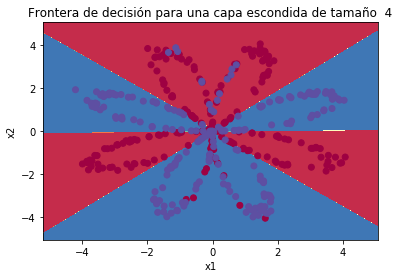

In [25]:
# Construya un modelo con una capa escondida de dimensión $n_h=4$
### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
parameters = nn_model(X, Y, n_h=4, num_iterations=10000, print_cost=True)
### TERMINE EL CÓDIGO AQUÍ ###

# Grafique la frontera de decisión
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y2)
plt.title("Frontera de decisión para una capa escondida de tamaño  " + str(4))

**Salida esperada**:

<table style="width:50%">
  <tr>
      
    <td>**Coste tras la iteración 9000**</td>
    <td> 0.218571 </td> 
  </tr>
  
</table>


In [26]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Salida esperada**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

La precisión ($Accuracy$) es alta comparada con los resultados de la regresión logística. El modelo ha aprendido los patrones de los datos (su forma en flor). Las redes neuronales pueden aprender fronteras de decisión en alto grado no-lineales, a diferencia de la regresión logística. 

Ahora, encuentre el mejor modelo al intentar distintos tamaños de la capa escondida.

### 4.6 - Optimize el tamaño de la capa escondida ###

De manera discreta, mediante un conjunto de posibles tamaños para la capa escondida (numero de neuronas en la capa escondida): hidden_layer_sizes = [1, 2, .. , H], encuentre el valor que logre los mejores resultados. Podrá observar distintos comportamientos del modelo para distintos tamaños de la capa escondida. 

Accuracy para 3 uniandes escondidas: 90.75 %
Accuracy para 5 uniandes escondidas: 91.25 %


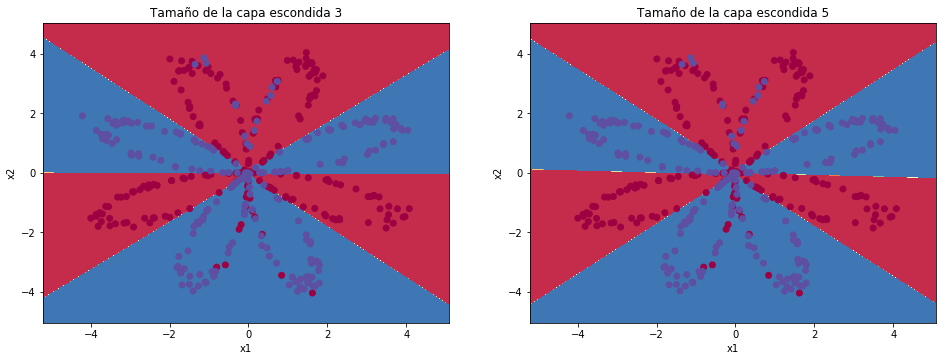

In [27]:
plt.figure(figsize=(16, 32))

### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
hidden_layer_sizes = [3,5]
### TERMINE EL CÓDIGO AQUÍ ###

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Tamaño de la capa escondida %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y2)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy para {} uniandes escondidas: {} %".format(n_h, accuracy))

In [28]:
parameters = nn_model(X, Y, n_h, num_iterations = 5000)
parameters

{'W1': array([[ 0.32402172,  9.20845769],
        [-1.58959291, -3.88669382],
        [-7.60711898, -9.02347677],
        [-2.0153122 ,  2.00108454],
        [ 7.70991851, -8.99278088]]),
 'W2': array([[8.95621009, 0.61322681, 5.97702851, 2.99632948, 7.00769979]]),
 'b1': array([[ 0.12556814],
        [-0.43701802],
        [-0.10987921],
        [-0.45117104],
        [ 0.19491364]]),
 'b2': array([[0.02171659]])}

**Interpretación**:
- Modelos más complejos (con más unidades escondidas) logran un mejor ajuste al conjunto de entrenamiento, hasta que eventualmente los modelos más grandes se sobreajustan a los datos. 
- EL mejor tamaño para la capa escondida para estar alrededor de $n_h = 5$. De esta manera, un valor de esta magnitud parece ajustarse a los datos de buena manera, controlando el posible sobreajuste. 
- Más adelante estudiaremos la regularización, permitiendo el uso de modelos más complejos (por ejemplo con $n_h = 50$) cuidando de no cometer un sobreajuste muy alto. 

**Preguntas sugeridas**:

Puede explorar qué ocurre si.. 
- ..cambia la función de activación de tanh a una activación sigmoide o ReLU?
- ..cambia la tasa de aprendizaje. 

Se consiguen mejores resultados? 


- Y qué pasa si cambiamos el conjunto de datos? (Ver el siguiente punto)

Puede elegir un conjunto de datos diferente, y probar qué ocurre al cambiar la función de activación o la tasa de aprendizaje. Visualize los resultados del mejor modelo.

## 5) Desempeño sobre otros conjuntos de datos 

Puede revisar o ejecutar de nuevo el modelo para (al menos uno de) los conjunto de datos a continuación. Recuerde presentar los resultados del mejor modelo con un gráfico de la frontera de decisión aprendida y su correspondiente medida de precisión ($accuracy$).

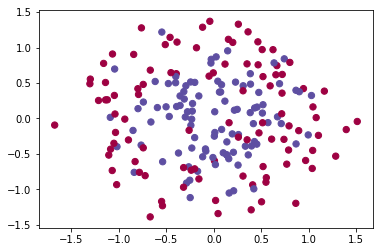

In [29]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### EMPIEZE EL CÓDIGO AQUÍ ### (elija el conjunto de datos)
dataset = "noisy_circles"
### TERMINE EL CÓDIGO AQUÍ ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# binariza los cúmulos o clusters (blobs)
if dataset == "blobs":
    Y = Y%2

# Visualiza los datos
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

In [30]:
plt.figure(figsize=(16, 32))

### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
hidden_layer_sizes = (8,5)
### TERMINE EL CÓDIGO AQUÍ ###

for i, n_h in enumerate(hidden_layer_sizes):
    #plt.subplot(5, 2, i+1)
    #plt.title('Tamaño de la capa escondida %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    #plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y2)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy para {} uniandes escondidas: {} %".format(n_h, accuracy))

Accuracy para 8 uniandes escondidas: 79.0 %
Accuracy para 5 uniandes escondidas: 78.0 %


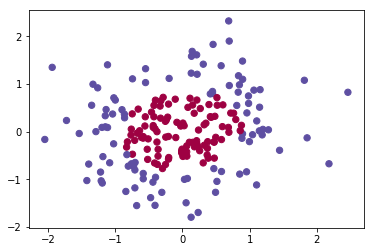

In [37]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### EMPIEZE EL CÓDIGO AQUÍ ### (elija el conjunto de datos)
dataset = "gaussian_quantiles"
### TERMINE EL CÓDIGO AQUÍ ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# binariza los cúmulos o clusters (blobs)
if dataset == "blobs":
    Y = Y%2

# Visualiza los datos
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

In [39]:
plt.figure(figsize=(16, 32))

### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
hidden_layer_sizes = (5,4)
### TERMINE EL CÓDIGO AQUÍ ###

for i, n_h in enumerate(hidden_layer_sizes):
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy para {} uniandes escondidas: {} %".format(n_h, accuracy))

Accuracy para 5 uniandes escondidas: 84.5 %
Accuracy para 4 uniandes escondidas: 97.5 %


Se obtuvo un accuracy en el modelo de 97.5% con un número de total de neuronas de 5

Cabe resaltar que la gráfica de frontera del nuevo DataSet presenta un error en la definición de lo colores en RGB pero al final de este error se muestra el gráfico correctamente.

ValueError: c of shape (400,) not acceptable as a color sequence for x with size 200, y with size 200

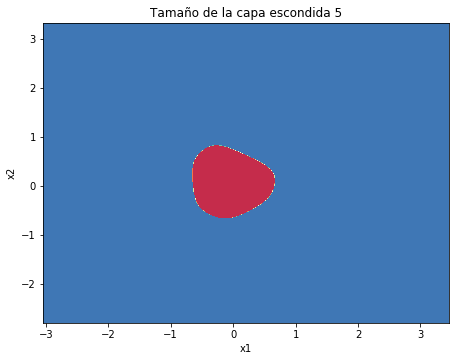

In [38]:
plt.figure(figsize=(16, 32))

### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
hidden_layer_sizes = (5,4)
### TERMINE EL CÓDIGO AQUÍ ###

for i, n_h in enumerate(hidden_layer_sizes):
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy para {} uniandes escondidas: {} %".format(n_h, accuracy))

<font color='blue'>
**En este taller debe haber aprendido a:**
- Construir una red neuronal completa con una capa escondida
- Hacer buen uso de una unidad no-lineal 
- Implementar propagación hacia delante y hacia atrás, y entrenar una red neuronal
- Ver el impacto de cambiar el tamaño de la capa escondida, junto con la comprensión del sobre-ajuste.

Referencias:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/